In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install neattext
import neattext.functions as nfx
import tensorflow as tf
import keras
from keras.models import load_model
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Embedding, Dense, LSTM,GlobalMaxPooling1D, Input, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
path = '/content/drive/MyDrive/ColabNotebooks/'
df = pd.read_csv(f'{path}Suicide_Detection.csv', on_bad_lines='skip')

In [4]:
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
df['class'].value_counts()

,count
class,
suicide,116037
non-suicide,116037


In [8]:
df['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

### Preprocess Data

In [14]:
# Train 80, val 10, test 10
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [20]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for t in tqdm(text):
        t = t.lower()
        t = nfx.remove_special_characters(t)
        t = nfx.remove_stopwords(t)
        text_length.append(len(t.split()))
        cleaned_text.append(t)
    return cleaned_text, text_length

In [22]:
train_text, train_text_len = clean_text(train_data['text'])
val_text, val_text_len = clean_text(val_data['text'])
test_text, test_text_len = clean_text(test_data['text'])

100%|██████████| 23208/23208 [00:04<00:00, 5302.15it/s]


In [29]:
len(train_text), len(val_text), len(test_text)

(185659, 23207, 23208)

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

In [26]:
train_text[:5]

['going kill sooni dont know know body mind completely sync ive convinced im going commit brain screamed id fucking kick chair im fucking nauseated cant stand cant stand breate second longer cant stand trapped body brain fucking thoughts need talk talk',
 'sub diary day 68 today great school stuff basically talked riot happened state left school early meetings started 9 finished 7 day',
 'supposed doive got problem years antisocial daily interactions people job quit job couldnt deal death threats negative corner punching bag employees customers job went extensive training apparently abused blamed everyones problems day stabbed chest left dead boss tried twist fault id everyones bullshit walked didnt realize mental damage years abuse cant talk people face face phone ive tomorrow pack stuff month served eviction notice im capable interacting human beings mental illness dont ability ask help ive tried year help mental problem failed honesty die leave home dont like world im forced live do

In [28]:
train_text_seq = tokenizer.texts_to_sequences(train_text)
train_text_pad = pad_sequences(train_text_seq, maxlen=50)

val_text_seq = tokenizer.texts_to_sequences(val_text)
val_text_pad = pad_sequences(val_text_seq, maxlen=50)


test_text_seq = tokenizer.texts_to_sequences(test_text)
test_text_pad = pad_sequences(test_text_seq, maxlen=50)

In [33]:
train_text_pad.shape, train_text_pad[0]

((185659, 50),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           13,    36,  4056,     2,     5,     5,   207,   130,   208,
        17987,     8,  1095,     1,    13,   442,   313,  2167,    96,
           22,  1367,  2151,     1,    22, 13958,     9,   480,     9,
          480, 87242,   296,   226,     9,   480,   819,   207,   313,
           22,    87,    26,    33,    33], dtype=int32))

### GloVe Embeddings

In [71]:
encoder = LabelEncoder()

train_output = encoder.fit_transform(train_data['class'])
val_output = encoder.transform(val_data['class'])
test_output = encoder.transform(test_data['class'])

In [72]:
import pickle

with open(f'{path}glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [73]:
v = len(tokenizer.word_index)
emb_matrix = np.zeros((v+1, 300), dtype=float)

for word, idx in tokenizer.word_index.items():
    emb_vector = glove_embedding.get(word)
    if emb_vector is not None:
        emb_matrix[idx] = emb_vector

In [74]:
emb_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.074482  ,  0.58293003, -0.78233999, ..., -0.24984001,
        -0.096953  ,  0.66692001],
       [-0.35394999,  0.23051   , -0.62689   , ..., -0.20720001,
         0.52003002,  0.51129001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Keras Sequential Model

In [75]:
early_stop = EarlyStopping(patience=5)
reducelr = ReduceLROnPlateau(patience=3)

In [76]:
model = Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1, 300, weights=[emb_matrix], trainable=False))
model.add(LSTM(20, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1, momentum=0.09),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 50, 300)             │      81,334,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 20)              │          25,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 20)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,365,813 (310.39 MB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 81,334,500 (310.27 MB)

In [79]:
r = model.fit(train_text_pad, train_output,
            validation_data=(val_text_pad, val_output),
            epochs=20, batch_size=256,
            callbacks=[early_stop, reducelr])

Epoch 1/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - accuracy: 0.8449 - loss: 0.3865 - val_accuracy: 0.8975 - val_loss: 0.2602 - learning_rate: 0.1000
Epoch 2/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 76s 104ms/step - accuracy: 0.8932 - loss: 0.2756 - val_accuracy: 0.8879 - val_loss: 0.2797 - learning_rate: 0.1000
Epoch 3/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 103s 134ms/step - accuracy: 0.8997 - loss: 0.2555 - val_accuracy: 0.9071 - val_loss: 0.2333 - learning_rate: 0.1000
Epoch 4/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 118s 101ms/step - accuracy: 0.9071 - loss: 0.2388 - val_accuracy: 0.9114 - val_loss: 0.2270 - learning_rate: 0.1000
Epoch 5/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 87s 107ms/step - accuracy: 0.9144 - loss: 0.2235 - val_accuracy: 0.9132 - val_loss: 0.2217 - learning_rate: 0.1000
Epoch 6/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 82s 108ms/step - accuracy: 0.9202 - loss: 0.2065 - val_accuracy: 0.9230 - val_loss: 0.1992 - learning_rate: 0.1000
Epoch 7/20
726/726 ━━━━━━━━━━━━━━━━━━━━ 85s 112ms/step - accuracy: 0

### Model Evaluation

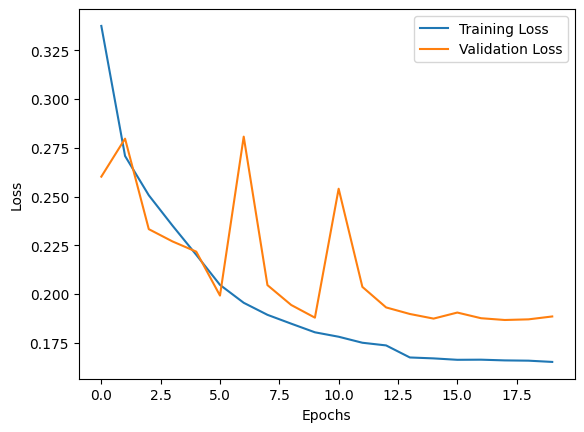

In [98]:
# Plot training history
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
t = ["I can't do this anymore. Every day feels like a battle, and I'm losing. The pain is too much to bear, and I don't see a way out. I've thought about ending it all, and it feels like the only way to escape this endless suffering. I'm so tired of fighting."]
t = tokenizer.texts_to_sequences(t)
t = pad_sequences(t, maxlen=50)

pred = model.predict(t)[0][0]
print(pred)

if(pred > 0.5):
    print('Potential Suicide Post')
else:
    print('Non Suicide Post')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
0.7736956
Potential Suicide Post


In [95]:
test_loss, test_accuracy = model.evaluate(test_text_pad, test_output)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

726/726 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9297 - loss: 0.1832
Test Loss: 0.18528947234153748
Test Accuracy: 0.9286453127861023


In [82]:
y_pred_prob = model.predict(test_text_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

726/726 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step


In [83]:
accuracy = accuracy_score(test_output, y_pred)
precision = precision_score(test_output, y_pred)
recall = recall_score(test_output, y_pred)
f1 = f1_score(test_output, y_pred)
roc_auc = roc_auc_score(test_output, y_pred_prob)

In [94]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')

Accuracy: 0.9286
Precision: 0.9444
Recall: 0.9098
F1-Score: 0.9268
ROC-AUC Score: 0.9802


In [93]:
conf_matrix = confusion_matrix(test_output, y_pred)
print('Confusion Matrix:')
print(conf_matrix)
print()

print('Classification Report:')
print(classification_report(test_output, y_pred))

Confusion Matrix:
[[11070   617]
 [ 1039 10482]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     11687
           1       0.94      0.91      0.93     11521

    accuracy                           0.93     23208
   macro avg       0.93      0.93      0.93     23208
weighted avg       0.93      0.93      0.93     23208



In [96]:
pickle.dump(tokenizer, open(f'{path}tokenizer.pkl', 'wb'))

model.save(f'{path}model.h5')